In [185]:
# Download the modules 
# If tensorflow not install in your system then uncomment the below code
# pip install tensorflow 

import tensorflow as tf    
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [181]:
#Assign the variables

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50
train_split_size = 0.8
test_split_size = 0.1
validate_split_size = 0.1


INPUT_SHAPE = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNEL)
ACTIVATION = 'relu'
KERNAL_SIZE = 3
FILTER_SIZE = 3
POLLING_SIZE = 2
DENSE_ACTIVATION = 'softmax'
n_classes = 3

OPTIMIZER = 'adam'
METRICS = 'accuracy'
VERBOSE = 1

images_directory_name = "PlantVillage"
model_save_path = "../saved_models/"

In [182]:
# Download the dataset into the tensorflow dataset
# Check your directory should be in the below format 

# PlantVillage
# .....Potato___Early_blight
#       ..... image_1.jpg
#       ..... image_2.jpg
# .....Potato___healthy
#       ..... image_1.jpg
#       ..... image_2.jpg
# .....Potato___Late_blight
#       ..... image_1.jpg
#       ..... image_2.jpg

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_directory_name,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [183]:
# Check the name for the three classes it should be same as the folder classes
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [109]:
# Check the length of the dataset 
# It should be number of images present in the folders divide by the batch size

len(dataset)

68


 32 Batch_size images shape:- (32, 256, 256, 3)

 Labels with repective 32 image:- [0 1 1 0 2 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 2 1 1 0 0 0 0 0]

 Print the first image :- In Tensorflow 
tf.Tensor(
[[[167. 171. 182.]
  [198. 202. 213.]
  [175. 179. 190.]
  ...
  [158. 160. 172.]
  [183. 185. 197.]
  [171. 173. 185.]]

 [[157. 161. 172.]
  [179. 183. 194.]
  [155. 159. 170.]
  ...
  [180. 182. 194.]
  [183. 185. 197.]
  [171. 173. 185.]]

 [[161. 165. 176.]
  [168. 172. 183.]
  [149. 153. 164.]
  ...
  [192. 194. 206.]
  [178. 180. 192.]
  [178. 180. 192.]]

 ...

 [[118. 115. 126.]
  [122. 119. 130.]
  [123. 120. 131.]
  ...
  [123. 127. 139.]
  [132. 136. 148.]
  [137. 141. 153.]]

 [[117. 114. 125.]
  [117. 114. 125.]
  [116. 113. 124.]
  ...
  [138. 142. 154.]
  [134. 138. 150.]
  [124. 128. 140.]]

 [[139. 136. 147.]
  [133. 130. 141.]
  [126. 123. 134.]
  ...
  [140. 144. 156.]
  [131. 135. 147.]
  [113. 117. 129.]]], shape=(256, 256, 3), dtype=float32)

 Print the first iamg

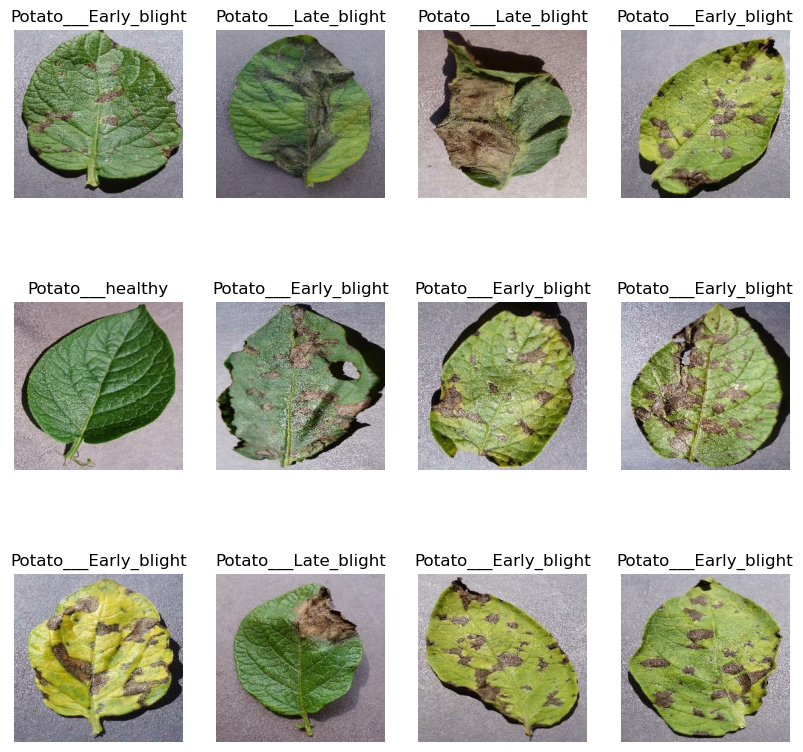

In [110]:
# Load the one batch of the images and labels
plt.figure(figsize = (10,10))

for image_batch , label_batch in dataset.take(1):
    print('\n Batch_size images shape:' , image_batch.shape)
    print('\n Labels with repective image:-',label_batch.numpy())
    
    print("\n Print the first image :- In Tensorflow ")
    print(image_batch[0])
    
    print("\n Print the first iamge :- In Numpy ")
    print(image_batch[0].numpy())
    
    print("\n Visualize the first 12 images:-")
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
    
    

In [111]:
# Split our dataset into Train, Test and validation dataset
# Train dataset split--> 80%
# Test dataset split--> 10%
# Validation dataset split--> 10%


def train_test_split(dataset , train_size = 0.8, validate_size = 0.1,  test_size = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(dataset)
    
    if shuffle :
        dataset = dataset.shuffle(shuffle_size , seed =12)
        
    train_length = int( ds_size * train_size)
    val_length = int(ds_size * validate_size)
    
    
    train_dataset = dataset.take(train_length)
    remain_dataset = dataset.skip(train_length)    
   
    validate_dataset = remain_dataset.take(val_length)
    test_dataset =  remain_dataset.skip(val_length)
    
    return train_dataset , validate_dataset, test_dataset  

In [112]:
train_dataset , validate_dataset, test_dataset  = train_test_split(dataset , 
                                                                   train_size = train_split_size, 
                                                                   validate_size = validate_split_size,
                                                                   test_size = test_split_size)

In [113]:
# To increase the performance of the pipeline
# Perform Caching - It will read the image from menory after the first read
# prefetching -- save the time reading the images

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validate_dataset = validate_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [114]:
# Preprocessing pipeline
# 1. Resize Image bys the IMAGE_SIZE - help while testing
# 2. Rescale Imge by Divind the 255

resize_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [115]:
# Data augumentation
# Perform horizontal and vertical flip and rotatation.

data_augumentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)   
    
])

In [116]:
# Create the convolution Neural Network Model
# The layers used in the CNN model are 
# -----convolution layers
# -----Max pooling layers
# -----Flatten layer
# -----Dense layer -> softmax function normalize the probability of the classes


model = models.Sequential([
    resize_rescale_layer,
    data_augumentation_layer,
    layers.Conv2D(32,(FILTER_SIZE,FILTER_SIZE), activation = ACTIVATION, input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , kernel_size = (KERNAL_SIZE, KERNAL_SIZE), activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , kernel_size = (KERNAL_SIZE,KERNAL_SIZE), activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , (FILTER_SIZE,FILTER_SIZE) , activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , (FILTER_SIZE,FILTER_SIZE) , activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Conv2D(64 , (FILTER_SIZE,FILTER_SIZE),  activation = ACTIVATION),
    layers.MaxPooling2D((POLLING_SIZE,POLLING_SIZE)),
    layers.Flatten(),
    layers.Dense(n_classes , activation = DENSE_ACTIVATION)  
])

model.build(input_shape = INPUT_SHAPE)

In [117]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_11 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [118]:
# Compile the model
model.compile(
    optimizer = OPTIMIZER,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = [METRICS],
)

In [119]:
# Train model after compile
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = VERBOSE ,
    validation_data = validate_dataset,    
)

Epoch 1/50
54/54 [==============================] - 222s 4s/step - loss: 0.9056 - accuracy: 0.4878 - val_loss: 0.9341 - val_accuracy: 0.4479
Epoch 2/50
54/54 [==============================] - 187s 3s/step - loss: 0.7016 - accuracy: 0.6869 - val_loss: 0.6195 - val_accuracy: 0.6719
Epoch 3/50
54/54 [==============================] - 187s 3s/step - loss: 0.4551 - accuracy: 0.8171 - val_loss: 0.4764 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 184s 3s/step - loss: 0.3281 - accuracy: 0.8675 - val_loss: 0.4790 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 187s 3s/step - loss: 0.2764 - accuracy: 0.8924 - val_loss: 0.3424 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 190s 4s/step - loss: 0.2157 - accuracy: 0.9155 - val_loss: 0.3461 - val_accuracy: 0.8438
Epoch 7/50
54/54 [==============================] - 197s 4s/step - loss: 0.1725 - accuracy: 0.9340 - val_loss: 0.1148 - val_accuracy: 0.9531
Epoch 8/50
54

In [121]:
# Run on the Test dataset to check the model accuracy
model.evaluate(test_dataset)

8/8 [==============================] - 11s 894ms/step - loss: 0.1245 - accuracy: 0.9570


[0.12453547865152359, 0.95703125]

In [122]:
# History --> It is keras callback history

accuracy = history.history['accuracy']
vaidation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

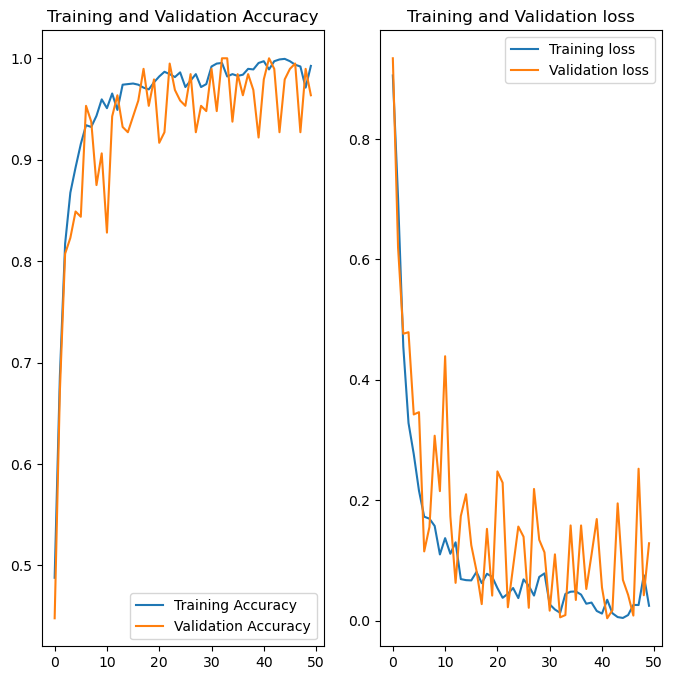

In [126]:
# Plot the Training and Validation Accuracy chart

plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy , label = 'Training Accuracy')
plt.plot(range(EPOCHS), vaidation_accuracy , label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Plot the Training and Validation loss chart
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss , label = 'Training loss')
plt.plot(range(EPOCHS), validation_loss , label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict:--

 Actual Label for the first image :- Potato___Late_blight
1/1 [==============================] - 1s 897ms/step
Predicted Label for the first image :- Potato___Late_blight


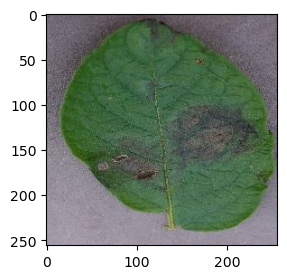

In [141]:
# Predict the test images 
for image_batch , label_batch in test_dataset.take(1):
    plt.figure(figsize=(3,3))
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to predict:--")
    plt.imshow(first_image)
    print("\n Actual Label for the first image :-", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    predicted_label_first = class_names[np.argmax(batch_prediction[0])]
    print("Predicted Label for the first image :-",predicted_label_first)    
    


In [161]:
# Create function to predict the image with specific model

def predict(model , images):
    img_array = tf.keras.preprocessing.image.img_to_array(images) # Converted image to array
    img_array = tf.expand_dims(img_array , 0) # Created batch 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])) ,2)
    return predicted_class , confidence

1/1 [==============================] - 0s 69ms/step


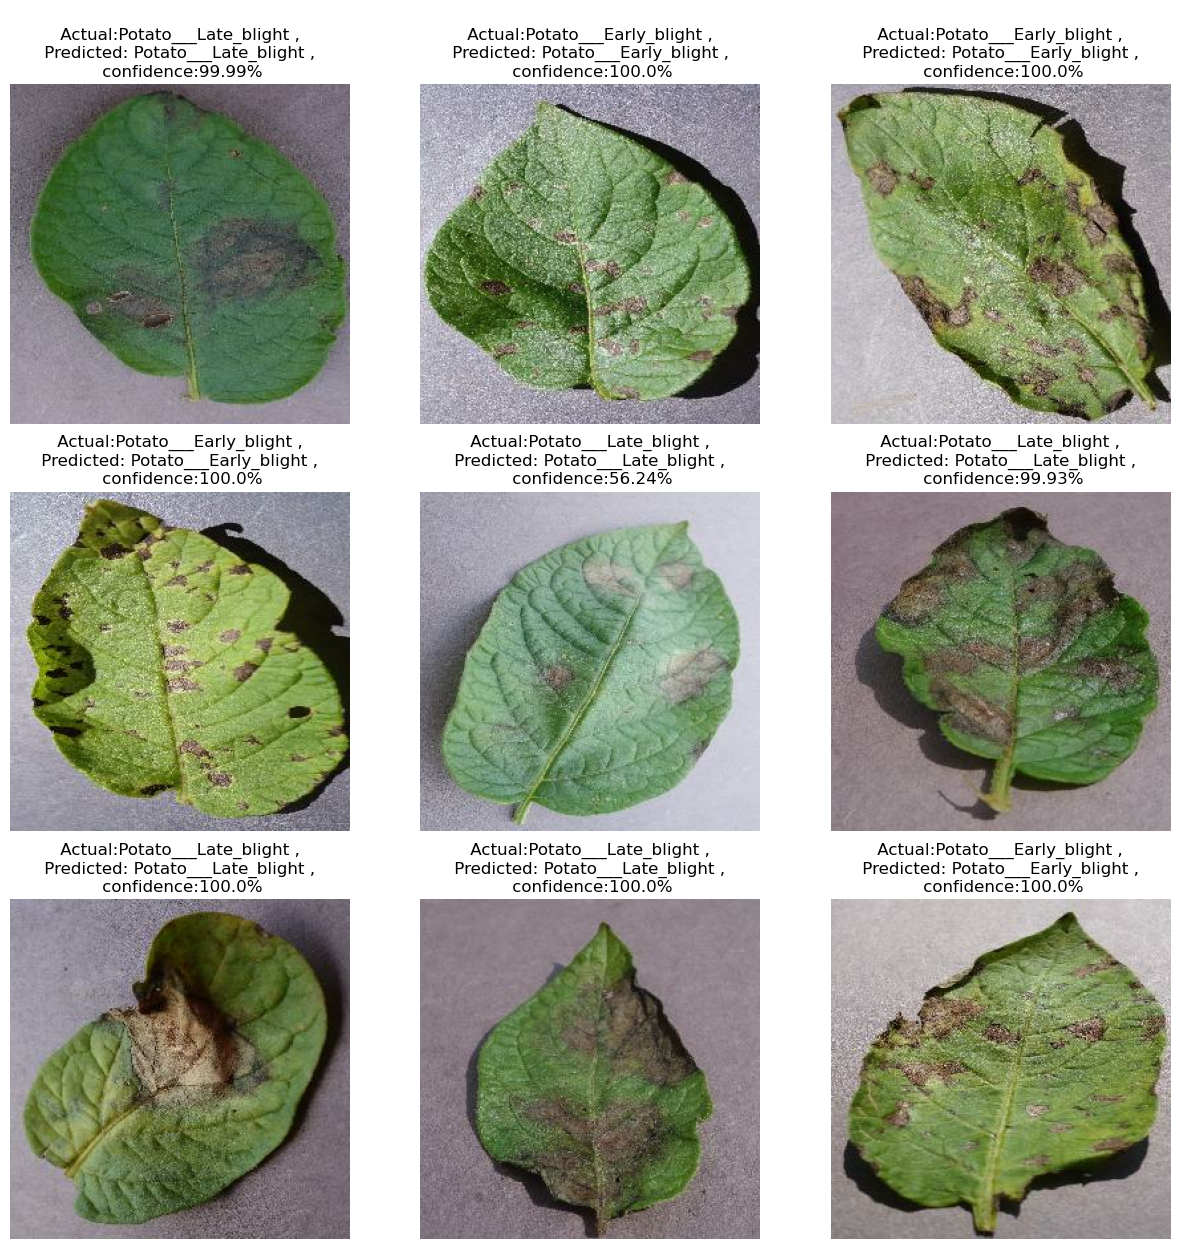

In [165]:
plt.figure(figsize=(15,15))
for image_batch , label_batch in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict(model , image_batch[i].numpy())
        actual_class = class_names[label_batch[i]]
        
        plt.title(f"\n Actual:{actual_class} , \n Predicted: {predicted_class} , \n confidence:{confidence}%")
        plt.axis('off')

In [178]:
# save Models  
# Model version will be auto increment 

model_version = max(int(i) for i in os.listdir(model_save_path) ) + 1
model.save(f"{model_save_path}{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
